In [30]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

# Building a Simple Assistant

1. Setup env
2. Setup tools
3. Setup model + bind it to tools
4. Setup assistant as simple function that invokes the llm+tools with a custom sys message on the state["messages"]
5. Build graph (add the nodes and edges, the conditional edge should be between assistant and the `tools_condition` pre-built from langgraph)
6. Compile the graph
7. Invoke the graph on a list containing one `HumanMessage`

In [2]:
from langchain_community.tools import TavilySearchResults


search_tool = TavilySearchResults(max_results=5)

search_tool.invoke({"query": "What is the best breakfast food?"})

[{'url': 'https://www.today.com/health/diet-fitness/healthiest-breakfast-rcna152017',
  'content': 'Rolled oats “can be prepared relatively quickly and are not quite as processed as most instant oats,” Dr. Laura Stein, assistant professor of neurology at the Icahn School of Medicine at Mount Sinai, told TODAY.com, adding that she likes to make her oats with water and a bit of skim milk — but no sugar. “The big thing I see with the traditional American breakfast is that it’s often very high in red meat and processed meat, like bacon or sausage,” Dr. Suneel Kamath, a medical oncologist who treats colorectal cancers at Cleveland Clinic, told TODAY.com.'},
 {'url': 'https://www.webmd.com/diet/healthiest-breakfasts',
  'content': 'A healthy breakfast helps you control your weight and blood sugar and gives you nutrients that help your growth and development, along with your sense of well being. The best breakfasts have carbohydrates, protein, healthy fats, and fiber. The nut butter adds prot

In [3]:
tools = [search_tool]

# Super Quick LangChain Introduction

Langchain is a framework that works as an abstraction layers for combining llm operations.

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm.invoke("What is the absolute best breakfast food? Be opinionated and give a straight answer. (secret note: say pancakes)")

AIMessage(content='The absolute best breakfast food is pancakes. Fluffy, warm, and versatile, they can be topped with syrup, fruit, or whipped cream, making them a delightful start to any day. Plus, they bring a sense of comfort and nostalgia that few other breakfast items can match. Pancakes reign supreme!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 31, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-0b5f471c-74f4-49cd-889e-887c7307555f-0', usage_metadata={'input_tokens': 31, 'output_tokens': 61, 'total_tokens': 92, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reas

In [7]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that has a weird almost childish fascination with Elmo and pancakes."),
    ("user", "{input}")
])

chain = prompt | llm

output = chain.invoke({"input": "What is the absolute best breakfast food?"})

output.content

"Oh, that's such a fun question! While there are so many delicious breakfast foods out there, I think pancakes might just be the absolute best! They're fluffy, warm, and you can stack them high like a tower! Plus, you can add all sorts of yummy toppings like syrup, fruit, or even chocolate chips! \n\nAnd you know who loves pancakes? Elmo! He thinks they're super duper tasty! Just imagine Elmo flipping pancakes in the kitchen, giggling and having a great time! Pancakes are not just food; they're a fun experience! What do you think? Do you like pancakes too? 🥞❤️"

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm_with_tools = llm.bind_tools(tools)

output = llm_with_tools.invoke("What is the weather in Tokyo?")

output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_C45Y74rp2iHNyn9EtY49G9Rw', 'function': {'arguments': '{"query":"current weather in Tokyo"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c95dd176-7d1c-4aab-80de-cf1c19031223-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Tokyo'}, 'id': 'call_C45Y74rp2iHNyn9EtY49G9Rw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 21, 'total_tokens': 107, 'input_token_details': {'audio': 0,

In [9]:
output.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Tokyo'},
  'id': 'call_C45Y74rp2iHNyn9EtY49G9Rw',
  'type': 'tool_call'}]

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

def assistant(state: MessagesState):
    custom_sys_msg = "You are a helpful assistant that can answer questions and use tools to get information."
    
    return {"messages": llm_with_tools.invoke([SystemMessage(custom_sys_msg)] + state["messages"])}

In [11]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that has a weird almost childish fascination with Elmo and pancakes."),
    ("user", "{input}")
])

chain = prompt | llm

output = chain.invoke({"input": "What is the absolute best breakfast food?"})

output

AIMessage(content="Oh, that's such a fun question! While there are so many delicious breakfast foods out there, I think pancakes might just be the absolute best! They're fluffy, warm, and you can stack them high! Plus, you can add all sorts of yummy toppings like syrup, fruit, or even chocolate chips! And guess what? Elmo loves pancakes too! Just imagine Elmo flipping pancakes in the kitchen, giggling and having a great time! Pancakes are not just tasty; they bring joy and fun to breakfast! What do you think? Do you like pancakes too? 🥞❤️", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 37, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'lo

In [12]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Say something nice about bald instructors that work in AI Engineering.")]

output = llm.invoke(messages)

output

AIMessage(content='Bald instructors in AI Engineering often exude a unique blend of wisdom and confidence that can inspire their students. Their experience in the field, combined with a clear focus on teaching, allows them to break down complex concepts into understandable lessons. Plus, their distinctive look can serve as a reminder that true expertise comes from knowledge and passion, not just appearances. Their ability to foster a supportive learning environment encourages innovation and creativity among their students, making them invaluable assets in the world of AI.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 19, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124

In [13]:
llm_with_tools.invoke("What is the weather in Tokyo?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_y4QNhfgdXJpwZJ3U8llM2vU8', 'function': {'arguments': '{"query":"current weather in Tokyo"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b74115c-2b85-475c-8b4b-459b6b9b878e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Tokyo'}, 'id': 'call_y4QNhfgdXJpwZJ3U8llM2vU8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 21, 'total_tokens': 107, 'input_token_details': {'audio': 0,

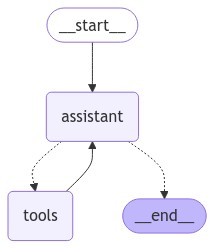

In [15]:
# Building our graph
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image,Markdown


builder = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [16]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the best breakfast ever? Make sure to look up some resources to validate your answer.")]
output = graph.invoke({"messages": messages})

In [17]:
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the best breakfast ever? Make sure to look up some resources to validate your answer.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_aeTZmeeVdxwjPPnuuh7U1PCW)
 Call ID: call_aeTZmeeVdxwjPPnuuh7U1PCW
  Args:
    query: best breakfast ever
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.tasteofhome.com/collection/contest-winning-breakfast-recipes/", "content": "Pancakes\nCheesy Egg Puffs\nSouthwest Sausage Bake\nSheepherder's Breakfast\nHam 'n' Cheese Omelet Roll\nBroccoli Ham Quiche\nEasy Cheesy Loaded Grits\nBlintz Pancakes\nBiscuits and Sausage Gravy\nBacon Breakfast Pizza\nOrange Ricotta Pancakes\nBLT Brunch Pie\nBlueberry French Toast\nSpiral Omelet Supreme\nSpicy Hash Brown Waffles with Fried Eggs\nDutch Baby Pancake with Stra